# Compute Latency

This example demonstrates how to use direct function calls of the low-level TAT-C library to perform latency analysis.

Similar to the _Collect Observations_ and _Compute Coverage_ examples, the first steps are to define the satellites for the mission. This example again uses the NOAA-20 satellite with a two-line elements model from July 2022 and a VIIRS instrument with field of regard computed based on a 834km altitude and 3000km swath width. Points are distributed over the globe with a 5000 km characteristic distance and observations are collected over a 30 day period starting on July 14, 2022 at noon UTC.

In [1]:
from tatc import utils
from tatc.schemas import Instrument, Satellite, TwoLineElements

viirs = Instrument(
    name="VIIRS",
    field_of_regard=utils.swath_width_to_field_of_regard(834000, 3000000),
    req_target_sunlit=True,
)
noaa20 = Satellite(
    name="NOAA 20",
    orbit=TwoLineElements(
        tle=[
            "1 43013U 17073A   22195.78278435  .00000038  00000+0  38919-4 0  9996",
            "2 43013  98.7169 133.9110 0001202  63.8768 296.2532 14.19561306241107",
        ]
    ),
    instruments=[viirs],
)

from tatc.generation import generate_equally_spaced_points

points_df = generate_equally_spaced_points(5000e3)

from tatc.schemas import Point

points = points_df.apply(
    lambda r: Point(id=r.point_id, latitude=r.geometry.y, longitude=r.geometry.x),
    axis=1,
)

from datetime import datetime, timedelta, timezone

start = datetime(year=2022, month=7, day=14, hour=12, tzinfo=timezone.utc)
end = start + timedelta(days=30)

from tatc.analysis import collect_observations
from joblib import Parallel, delayed
import pandas as pd

observations_list = Parallel(n_jobs=-1)(
    delayed(collect_observations)(point, noaa20, start, end) for point in points
)
observations = pd.concat(observations_list, ignore_index=True)
display(observations)

,point_id,geometry,satellite,instrument,start,end,epoch,sat_alt,sat_az
0,0,POINT Z (-157.51699 -67.51699 0),NOAA 20,VIIRS,2022-07-26 23:05:45.258746+00:00,2022-07-26 23:08:44.580526+00:00,2022-07-26 23:07:14.919636+00:00,23.232376,96.383771
1,0,POINT Z (-157.51699 -67.51699 0),NOAA 20,VIIRS,2022-07-30 23:30:00.700453+00:00,2022-07-30 23:35:11.668269+00:00,2022-07-30 23:32:36.184361+00:00,29.980441,90.571477
2,0,POINT Z (-157.51699 -67.51699 0),NOAA 20,VIIRS,2022-07-31 01:09:44.380087+00:00,2022-07-31 01:17:23.069693+00:00,2022-07-31 01:13:33.724890+00:00,83.932517,71.659563
3,0,POINT Z (-157.51699 -67.51699 0),NOAA 20,VIIRS,2022-07-31 23:11:40.551119+00:00,2022-07-31 23:15:24.047070+00:00,2022-07-31 23:13:32.299094500+00:00,24.749767,94.883549
4,0,POINT Z (-157.51699 -67.51699 0),NOAA 20,VIIRS,2022-08-01 00:50:55.502645+00:00,2022-08-01 00:58:28.482647+00:00,2022-08-01 00:54:41.992646+00:00,70.126386,72.613305
...,...,...,...,...,...,...,...,...,...
2169,31,POINT Z (157.24514 67.38106 0),NOAA 20,VIIRS,2022-08-12 18:28:51.557986+00:00,2022-08-12 18:34:04.353232+00:00,2022-08-12 18:31:27.955609+00:00,31.258697,324.067710
2170,31,POINT Z (157.24514 67.38106 0),NOAA 20,VIIRS,2022-08-12 21:48:45.630367+00:00,2022-08-12 21:49:49.415577+00:00,2022-08-12 21:49:17.522972+00:00,21.115155,12.621024
2171,31,POINT Z (157.24514 67.38106 0),NOAA 20,VIIRS,2022-08-12 23:25:37.442375+00:00,2022-08-12 23:31:05.304568+00:00,2022-08-12 23:28:21.373471500+00:00,32.779326,36.304442
2172,31,POINT Z (157.24514 67.38106 0),NOAA 20,VIIRS,2022-08-13 01:04:22.215027+00:00,2022-08-13 01:11:48.221137+00:00,2022-08-13 01:08:05.218082+00:00,73.798507,55.756224


Latency analysis measures the interval between observations and downlink to the first ground station. The following specifies a ground station at Hoboken with a 10-degree minimum elevaiton angle for downlink.

In [2]:
from tatc.schemas import GroundStation

hoboken = GroundStation(
    name="Hoboken", latitude=40.74259, longitude=-74.02686, min_elevation_angle=10
)

from tatc.analysis import collect_downlinks

downlinks = collect_downlinks(hoboken, noaa20, start, end)
display(downlinks)

,station,geometry,satellite,start,end,epoch
0,Hoboken,POINT Z (-74.02686 40.74259 0),NOAA 20,2022-07-14 17:12:43.763296+00:00,2022-07-14 17:22:57.456044+00:00,2022-07-14 17:17:50.609670+00:00
1,Hoboken,POINT Z (-74.02686 40.74259 0),NOAA 20,2022-07-14 18:54:04.803537+00:00,2022-07-14 19:02:25.062501+00:00,2022-07-14 18:58:14.933019+00:00
2,Hoboken,POINT Z (-74.02686 40.74259 0),NOAA 20,2022-07-15 05:32:06.654997+00:00,2022-07-15 05:39:35.858756+00:00,2022-07-15 05:35:51.256876500+00:00
3,Hoboken,POINT Z (-74.02686 40.74259 0),NOAA 20,2022-07-15 07:11:08.223574+00:00,2022-07-15 07:21:37.089606+00:00,2022-07-15 07:16:22.656590+00:00
4,Hoboken,POINT Z (-74.02686 40.74259 0),NOAA 20,2022-07-15 16:54:27.877548+00:00,2022-07-15 17:03:52.170605+00:00,2022-07-15 16:59:10.024076500+00:00
...,...,...,...,...,...,...
115,Hoboken,POINT Z (-74.02686 40.74259 0),NOAA 20,2022-08-12 08:28:09.529139+00:00,2022-08-12 08:32:42.603014+00:00,2022-08-12 08:30:26.066076500+00:00
116,Hoboken,POINT Z (-74.02686 40.74259 0),NOAA 20,2022-08-12 16:30:12.255865+00:00,2022-08-12 16:37:46.514194+00:00,2022-08-12 16:33:59.385029500+00:00
117,Hoboken,POINT Z (-74.02686 40.74259 0),NOAA 20,2022-08-12 18:08:28.080213+00:00,2022-08-12 18:19:02.956149+00:00,2022-08-12 18:13:45.518181+00:00
118,Hoboken,POINT Z (-74.02686 40.74259 0),NOAA 20,2022-08-13 06:26:51.204464+00:00,2022-08-13 06:37:31.285805+00:00,2022-08-13 06:32:11.245134500+00:00


Finally, latencies are computed by comparing the observations and downlink opportunities.

In [3]:
from tatc.analysis import compute_latencies

latencies = compute_latencies(observations, downlinks)
display(latencies)

,point_id,geometry,satellite,instrument,sat_alt,sat_az,station,downlinked,latency,observed
0,20,POINT Z (22.34708 22.41505 0),NOAA 20,VIIRS,46.686116,260.777813,Hoboken,2022-07-14 17:17:50.609670+00:00,0 days 05:10:34.144994500,2022-07-14 12:07:16.464675500+00:00
1,28,POINT Z (22.34708 67.38106 0),NOAA 20,VIIRS,29.024717,271.880297,Hoboken,2022-07-14 17:17:50.609670+00:00,0 days 04:57:46.494320,2022-07-14 12:20:04.115350+00:00
2,27,POINT Z (-22.61894 67.38106 0),NOAA 20,VIIRS,48.704552,49.346995,Hoboken,2022-07-14 17:17:50.609670+00:00,0 days 04:56:13.129769,2022-07-14 12:21:37.479901+00:00
3,25,POINT Z (-112.55097 67.38106 0),NOAA 20,VIIRS,31.323022,324.299192,Hoboken,2022-07-14 17:17:50.609670+00:00,0 days 04:47:32.626919500,2022-07-14 12:30:17.982750500+00:00
4,24,POINT Z (-157.51699 67.38106 0),NOAA 20,VIIRS,55.694847,103.325667,Hoboken,2022-07-14 17:17:50.609670+00:00,0 days 04:44:55.809464,2022-07-14 12:32:54.800206+00:00
...,...,...,...,...,...,...,...,...,...,...
2169,26,POINT Z (-67.58495 67.38106 0),NOAA 20,VIIRS,28.848897,327.376449,None,NaT,NaT,2022-08-13 09:44:37.403851500+00:00
2170,5,POINT Z (67.3131 -67.51699 0),NOAA 20,VIIRS,78.725002,245.320118,None,NaT,NaT,2022-08-13 10:37:41.608547500+00:00
2171,20,POINT Z (22.34708 22.41505 0),NOAA 20,VIIRS,35.605265,70.967792,None,NaT,NaT,2022-08-13 11:04:24.936363+00:00
2172,28,POINT Z (22.34708 67.38106 0),NOAA 20,VIIRS,56.654314,258.438321,None,NaT,NaT,2022-08-13 11:16:22.849990500+00:00


Similar to _Coverage Analysis_, latency analysis can also be reduced to compute descriptive statistics for each observation point.

In [4]:
from tatc.analysis import reduce_latencies

reduced_results = reduce_latencies(latencies)
display(reduced_results)

,point_id,geometry,latency,samples
0,0,POINT Z (-157.51699 -67.51699 0),0 days 05:10:59.268689,31
1,1,POINT Z (-112.55097 -67.51699 0),0 days 08:14:18.836280,31
2,2,POINT Z (-67.58495 -67.51699 0),0 days 04:21:48.654757,30
3,3,POINT Z (-22.61894 -67.51699 0),0 days 01:17:44.394353,31
4,4,POINT Z (22.34708 -67.51699 0),0 days 04:08:15.422021,31
5,5,POINT Z (67.3131 -67.51699 0),0 days 08:42:06.877307,31
6,6,POINT Z (112.27912 -67.51699 0),0 days 02:43:07.838991,33
7,7,POINT Z (157.24514 -67.51699 0),0 days 02:19:26.312887,34
8,8,POINT Z (-157.51699 -22.55097 0),0 days 05:44:31.317841,34
9,9,POINT Z (-112.55097 -22.55097 0),0 days 08:37:46.021444,34


Finally, GeoPlot can visualize the geospatial data.

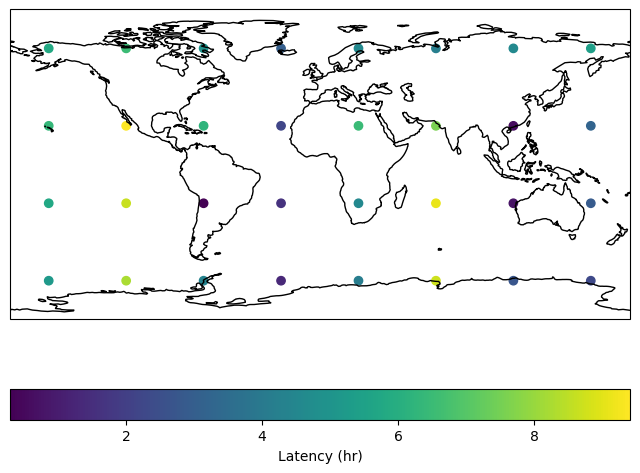

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

reduced_results["latency_hr"] = reduced_results.latency / timedelta(hours=1)

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree()})
reduced_results.plot(
    column="latency_hr",
    legend=True,
    legend_kwds={"label": "Latency (hr)", "orientation": "horizontal"},
    ax=ax,
    transform=ccrs.PlateCarree()
)
ax.coastlines()
ax.set_global()
plt.show()

Similar to _Coverage Analysis_, cells can also be used to aggregate descriptive statistics.  Note that, when working on the reduced results, the revisit aggregation function must perform a weighted average based on the number of samples for each point.

In [6]:
from tatc.generation.cells import generate_equally_spaced_cells

cells_df = generate_equally_spaced_cells(5000e3)

import numpy as np

grid_results = (
    cells_df.sjoin(reduced_results, how="inner", predicate="contains")
    .dissolve(
        by="cell_id",
        aggfunc={
            "samples": "sum",
            "latency_hr": lambda r: np.average(
                r, weights=reduced_results.loc[r.index, "samples"]
            ),
        },
    )
    .reset_index()
)
display(grid_results)

,cell_id,geometry,samples,latency_hr
0,0,"POLYGON Z ((-135.03398 -90 0, -135.03398 -45.0...",31,5.183130
1,1,"POLYGON Z ((-90.06796 -90 0, -90.06796 -45.033...",31,8.238566
2,2,"POLYGON Z ((-45.10194 -90 0, -45.10194 -45.033...",30,4.363515
3,3,"POLYGON Z ((-0.13593 -90 0, -0.13593 -45.03398...",31,1.295665
4,4,"POLYGON Z ((44.83009 -90 0, 44.83009 -45.03398...",31,4.137617
5,5,"POLYGON Z ((89.79611 -90 0, 89.79611 -45.03398...",31,8.701910
6,6,"POLYGON Z ((134.76213 -90 0, 134.76213 -45.033...",33,2.718844
7,7,"POLYGON Z ((179.72815 -90 0, 179.72815 -45.033...",34,2.323976
8,8,"POLYGON Z ((-135.03398 -45.03398 0, -135.03398...",34,5.742033
9,9,"POLYGON Z ((-90.06796 -45.03398 0, -90.06796 -...",34,8.629450


Finally, plotting can illustrate the latency over global regions.

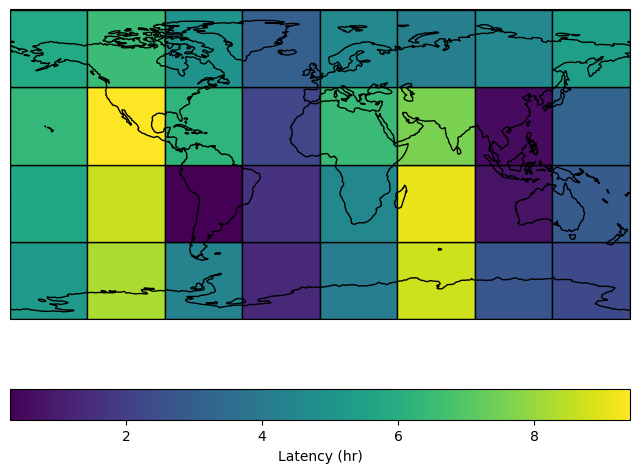

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree()})
grid_results.plot(
    column="latency_hr",
    cmap="viridis",
    edgecolor="k",
    legend=True,
    legend_kwds={"label": "Latency (hr)", "orientation": "horizontal"},
    ax=ax,
)
ax.coastlines()
ax.set_global()
plt.show()